**CS-GY 9223: Deep Learning Final Project: Solving Natural Language Processing with Disaster Tweets on Kaggle with BERT**

by:

Yan Sun    <ys3928@nyu.edu>

Zhenming Wang <zw2365@nyu.edu>

**Section 3: BERT As Embedding**

Reference: (https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca)

# Step 0: Set Up Working Environment And Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Deep Learning Final Project"   
                                       
%cd /content/gdrive/My Drive/Deep Learning Final Project

!pwd

/content/gdrive/My Drive/Deep Learning Final Project
/content/gdrive/My Drive/Deep Learning Final Project


In [3]:
!pip install -qq transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Detect GPU
if torch.cuda.is_available():   
   device = torch.device("cuda")
   print('Using GPU ', torch.cuda.get_device_name(0))
else:
   device = torch.device("cpu")
   print('Using CPU')

     |████████████████████████████████| 1.4MB 7.0MB/s 
     |████████████████████████████████| 890kB 43.8MB/s 
     |████████████████████████████████| 2.9MB 42.6MB/s 
Using GPU  Tesla P100-PCIE-16GB


# Step 1: BERT Preprocessing

## 1.1 Read input data into dataframse

In [4]:
# Read in the data cleaned data files 
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')


In [5]:
train.head()

,Unnamed: 0,id,keyword,location,text,target
0,0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


## 1.2 Helper function for tokenization and dataloader

In [6]:
# Helper function to tokenize a dataset using BERT tokenizer
class DisasterTweetDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [7]:
# Helper function to create dataloaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    text=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## 1.3 BERT As Embedding Model

In [8]:
class BertCNN(nn.Module):
  def __init__(self, n_classes):
    super(BertCNN, self).__init__()
    self.max_len = MAX_LEN
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    for param in self.bert.parameters():
      param.requires_grad = False

    # 768 * 4 since we use last_four_concat so that each 
    # token is a 768*4 dim vector
    # We use 100 filters
    # filter_size = 2
    self.conv1 = nn.Conv1d(768*4, 100, 2)
    self.conv2 = nn.Conv1d(768*4, 100, 3)
    self.conv3 = nn.Conv1d(768*4, 100, 4)

    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(300, n_classes) # 300 since we use 3 convolutions each with 100 filters


  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      output_hidden_states=True
    )

    # Concatinate the last four hidden layers so that
    # x will have the shape (batch_size, max_length, 4 * # of hidden units)
    x = torch.cat((outputs[2][-1], 
            outputs[2][-2],
            outputs[2][-3],
            outputs[2][-4]),
            dim=2)
    
    # reshape x for convolution layer
    x = x.view(x.size(0), x.size(2), x.size(1))

    # x1, x2, x3 have the shape (batch_size, 100, L_out)
    x1 = F.relu(self.conv1(x))
    x2 = F.relu(self.conv2(x))
    x3 = F.relu(self.conv3(x))

    # x1, x2, x3 have the shape (batch_size, 100, 1)
    x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
    x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
    x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)

    x = torch.cat((x1, x2, x3), 1)
    x = self.drop(x)

    x = self.linear(x)
    return x

## 1.4 Training and Evaluating Epoch

In [9]:
# This method defines the operations in one trainning epoch
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0


  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [10]:
# This method defines the operations in one evaluating epoch
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

# Step 2: Training

### Train BertCNN

In [16]:
# Define some constants
lr = 2e-5

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
EPOCHS = 10
BATCH_SIZE = 32
DROPOUT = 0.3
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [17]:
# Split the training data into train and validation set
train_data, val_data = train_test_split(train, test_size = 0.2, random_state=RANDOM_SEED) 

# Create dataloaders for training and validation set
train_data_loader = create_data_loader(train_data, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, TOKENIZER, MAX_LEN, BATCH_SIZE)

# Create model instance
model = BertCNN(2)
model = model.to(device)

# Define optimizer, loss fucntion and scheduler
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


# Train the model for some number of epochs
history = defaultdict(list)

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # Train
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # Validate
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_data)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)



Epoch 1/10
----------
Train loss 0.5286050378028011 accuracy 0.7476190476190476
Val   loss 0.4419578639790416 accuracy 0.8194353250164149
Epoch 2/10
----------
Train loss 0.41997399317656514 accuracy 0.816256157635468
Val   loss 0.4378190493832032 accuracy 0.8220617202889035
Epoch 3/10
----------
Train loss 0.37891779793182595 accuracy 0.8346469622331691
Val   loss 0.42843137712528306 accuracy 0.8279711096520026
Epoch 4/10
----------
Train loss 0.36149116703040934 accuracy 0.8448275862068966
Val   loss 0.42689320631325245 accuracy 0.8253447143795141
Epoch 5/10
----------
Train loss 0.3454471680662395 accuracy 0.855008210180624
Val   loss 0.4287050444011887 accuracy 0.829940906106369
Epoch 6/10
----------
Train loss 0.33513169567934503 accuracy 0.8635467980295567
Val   loss 0.42919710899392766 accuracy 0.8240315167432698
Epoch 7/10
----------
Train loss 0.3314782273784982 accuracy 0.8617405582922825
Val   loss 0.42786641387889784 accuracy 0.8246881155613919
Epoch 8/10
----------
Train l

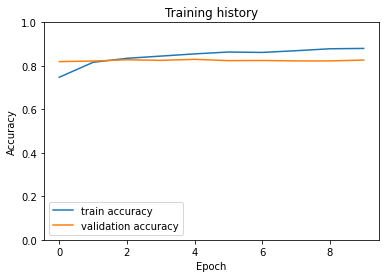

In [18]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Test BertCNN

In [19]:
BATCH_SIZE = 32
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
# Create test dataloader
test_data_loader = create_data_loader(test, TOKENIZER, MAX_LEN, BATCH_SIZE)

In [21]:
# Make prediction on test set
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

In [22]:
test_acc.item()

0.6346920012258658